# Exploration of Prosper Loan Data
## by Truls Møller

## Introduction

The Prosper Loan dataset is a file on 113,937 personal loans that were originated 2006 - 2014, a time range which does include the 2008 Financial Crisis.

My analysis will focus on:
- **High-level overview** of the data.
- **Variables that seem (at least to me) relevant to decisions by the Lender _at the time a new loan gets originated_**, with the help of univariate plots to answer any questions that may arise.
- **Interaction between the variables** with the help of bivariate and multivariate plots to answer any questions that may arise on the interactions.

My analysis will _not_ focus on:
- Variables that become relevant in case of payment problems - defaulted and chargedoff loans - variables such as credit lines, recovery payments.

Here is a breakdown of the relevant variables in three categories.

1) BASIC LOAN DATA
- ListingCategory (numeric) : The category of listing. 20 categories from Debt Consolidation to Wedding Loans denoted with a number in the range 0-20 without any description.
- **ListingCategory** The category of listing. 20 categories from Debt Consolidation to Wedding Loans denoted with a number in the range 0-20 _with_ description.
- **LoanOriginationDate**: The date the loan was originated.
- **Year**: Just the year extracted from the LoanOrigination date 
- **LoanOriginalAmount** : The origination amount of the loan.
- **BorrowerAPR**: The Borrower’s Annual Percentage Rate for the loan. (Yearly interest rate)
- **Term**: The duration of the loan in months (Three different durations found: 12, 36, 60 months, ie. 1, 3, 5 years)
- **Loan Status**: The current status of the loan: Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a time range on how long it is past due.

2) CREDIT GRADES / PROSPER RATINGS DATA
- CreditGrade : The Credit rating that was assigned at the time the listing went live. Used for listings pre-2009 only.
- ProsperRating (Alpha) : The Prosper Rating assigned at the time the listing was created, between AA - HR. Used for listings post-2008 only, hence complementary to CreditGrade.
- **ProsperRating** : Added column. It is the same as 'ProsperRating (Alpha)' only the missing data are populated from CreditGrade. This provides a nice continuity over time.
- **CreditScore** is the middle of the range between CreditScoreRangeLower and CreditScoreRangeUpper, which describe the borrower's credit score as provided by a consumer credit rating agency. This score might be used as a component when Prosper calculate a ProsperRating for the borrower.

3) DATA THAT MIGHT HAVE AFFECTED PROSPER RATINGS
- **EmploymentStatus** Whether the borrower is employed, full-time, part-time, retired etc.
- **IncomeRange** : The income range of the borrower at the time the listing was created.
- **Borrower State** Two letter abbreviation of the state of the address of the borrower at the time of listing.
- **IsBorrowerHomeowner** True or False.
- **OnTimeProsperPayments** : Number of past on time payments (less that one month late) at the time of listing. Null if there are no prior loan history.
- **Recommendations** : Number of recommendations the borrower had at the time of listing.

All these variables will be used in our analysis, but only the ones in **bold** will be used explicitly.

## Preliminary Wrangling

In [1]:
# import all packages, set plots to be embedded inline, 
# set max display metrics 
# and the seaborn first color in palette as base_color

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

base_color = sb.color_palette()[0]

Loading the dataset:

In [2]:
df = pd.read_csv('prosperLoanData.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN

High level overview of data shape and composition:

In [3]:
print(df.shape)
print(df.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


We do some conversions of data type:

In [4]:
# We convert the 'Date' columns to datetime format

date_columns = ['ListingCreationDate', 'ClosedDate', 'DateCreditPulled', 'LoanOriginationDate']

for i in date_columns:
    df[i]= pd.to_datetime(df[i]).dt.normalize()

In [5]:
# We also add a new column with for the Loan Origination YEAR, just called 'Year'.

df['Year'] = df['LoanOriginationDate'].dt.year

In [6]:
# We convert 'ListingNumber' and 'Term' to string type

df['ListingNumber'] = df['ListingNumber'].astype('str')
df['Term'] = df['Term'].astype('str')

Before we do conversions for categorical variables, we create a new column 'ProsperRating' where we first take all the data from column 'ProsperRating (Alpha)'s and then populate its missing values (pre-2009) with data from 'CreditGrade'. 

Note: This isn't perfect, but it follows the same rating scale (AA - A - B - C - D - E - HR), so it will give us some nice continuity across a gap in the data around the time of the 2008 financial crisis.

In [7]:
# We create the new column where we first take all the data from column 'ProsperRating (Alpha)'s 
# and then populate its missing values (pre-2009) with data from 'CreditGrade'.

df['ProsperRating'] = df['ProsperRating (Alpha)'].fillna(df['CreditGrade'])

# We check for missing data in our new column
df['ProsperRating'].isna().sum()

131

In [8]:
# We remove the missing data with pandas notnull function

df = df[pd.notnull(df['ProsperRating'])]

In [9]:
# The CreditGrade column also carried an extra value 'NC', 
# which we interpret as missing data as well ("Not Counted")

df['ProsperRating'].value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
NC      141
Name: ProsperRating, dtype: int64

In [10]:
# We remove that as well

df = df[df.ProsperRating != 'NC']

We verify that we only have the mentioned ratings

In [11]:
df['ProsperRating'].value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
Name: ProsperRating, dtype: int64

Great.

In [12]:
# We also remove the missing data in 'BorrowerAPR' with pandas notnull function

df = df[pd.notnull(df['BorrowerAPR'])]

One more step before we can move on to conversions for categorical variables:

In [13]:
# We want to add a column 'ListingCategory' and populate it 
# based on 'ListingCategory (numeric)'.

# First we create a dict for mapping between them
d = {0 : '0. Not Available',
     1 : '1. Debt Consolidation',
     2 : '2. Home Improvement', 
     3 : '3. Business', 
     4 : '4. Personal Loan', 
     5 : '5. Student Use',
     6 : '6. Auto',
     7 : '7. Other',
     8 : '8. Baby and Adoption', 
     9 : '9. Boat', 
     10 : '10. Cosmetic Procedure', 
     11 : '11. Engagement Ring',
     12 : '12. Green Loans',
     13 : '13. Household Expenses',
     14 : '14. Large Purchases',
     15 : '15. Medical/Dental',
     16 : '16. Motorcycle',
     17 : '17. RV',
     18 : '18. Taxes',
     19 : '19. Vacation',
     20 : '20. Wedding Loans'}

# we initialize the new column:

df['ListingCategory'] = '0. Not Available'

# and then we populate it.

for key in d:
    df.loc[df['ListingCategory (numeric)'] == key,'ListingCategory'] = d[key]

Great. Now we will perform conversions for categorical variables

In [14]:
# We convert Term, LoanStatus, ListingCategory and IncomeRange
# into ordered categorical types.

ordinal_var_dict = {'Term': ['12','36','60'],
                    'LoanStatus': ['Current', 'Completed','FinalPaymentInProgress', 
                                   'Past Due (1-15 days)', 'Past Due (16-30 days)', 
                                   'Past Due (31-60 days)', 'Past Due (61-90 days)', 
                                   'Past Due (90-120 days)', 'Past Due (>120 days)', 
                                   'Chargedoff', 'Defaulted'],
                    'ListingCategory': list(d.values()),
                    'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'],
                    'EmploymentStatus': ['Employed', 'Self-employed', 'Full-time', 'Part-time', 'Retired', 'Other', 'Not employed', 'Not available'], 
                    'ProsperRating': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

Let us inspect the data types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113641 entries, 0 to 113936
Data columns (total 84 columns):
ListingKey                             113641 non-null object
ListingNumber                          113641 non-null object
ListingCreationDate                    113641 non-null datetime64[ns]
CreditGrade                            28788 non-null object
Term                                   113641 non-null category
LoanStatus                             113332 non-null category
ClosedDate                             54793 non-null datetime64[ns]
BorrowerAPR                            113641 non-null float64
BorrowerRate                           113641 non-null float64
LenderYield                            113641 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64


We see that the categorical data types are indeed there, and among them at the very bottom of the output we notice our new columns 'ListingCategory' and 'ProsperRating'.

Next, we will add a new column 'CreditScore' will will be the average of 'CreditScoreRangeLower' and 'CreditScoreRangeUpper'.

In [16]:
# We see there are some outliers in the low end
df.CreditScoreRangeLower.describe()

count    113085.000000
mean        686.326215
std          62.303408
min           0.000000
25%         660.000000
50%         680.000000
75%         720.000000
max         880.000000
Name: CreditScoreRangeLower, dtype: float64

In [17]:
# We see there are some outliers in the low end
df.CreditScoreRangeUpper.describe()

count    113085.000000
mean        705.326215
std          62.303408
min          19.000000
25%         679.000000
50%         699.000000
75%         739.000000
max         899.000000
Name: CreditScoreRangeUpper, dtype: float64

In [18]:
# We drop the rows with credit score range less than 400. There turns out to be four of them.

ind = df[(df.CreditScoreRangeLower < 400) | (df.CreditScoreRangeUpper < 400)].index
ind

Int64Index([61268, 88167, 95983, 113714], dtype='int64')

In [19]:
df = df.drop(ind)

We verify

In [21]:
df[(df.CreditScoreRangeLower < 400) | (df.CreditScoreRangeUpper < 400)].index

Int64Index([], dtype='int64')

The outliers are indeed removed. Now we can create 'CreditScore'

In [22]:
df['CreditScore'] = (df['CreditScoreRangeUpper'] + df['CreditScoreRangeLower'])/2.0

It is created.

### What is the structure of the dataset?

In [23]:
df.shape

(113637, 85)

There were initially 113,937 loan listings (rows) and 81 variables of data (columns) in the raw dataset.
We have dropped some rows due to missing data or outliers, and we have added three new columns: 'ProsperRating', 'ListingCategory' and 'CreditScoreAvg'.
Now we have 113,637 loan listings (rows) and 85 variables of data (columns).

As stated in the Introduction, we will focus on 15 variables:
- 1 is a datetime variable: 'LoanOriginationDate'.
- 6 are categorical variables: 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange', 'EmploymentStatus' and 'ProsperRating'.
- 6 are numeric variables: 'Year', 'LoanOrginationAmount', 'BorrowerAPR', 'CreditScoreAvg' 'OnTimeProsperPayments', 'Recommendations'.
- 1 is a boolean variable: 'IsBorrowerHomeowner'.
- 1 is of string format: 'BorrowerState'.


### What is/are the main feature(s) of interest in the dataset?

As stated in the Introduction, I will focus on the variables that seem relevant to decisions by the Lender at the time a new loan gets originated, as well as the clearly dependent variables 'ProsperRating' and 'BorrowerAPR'.

I am interested to find out:
- How does ProsperRating and the borrower’s APR (annual percentage rate) correlate?
- And how do they correlate with CreditScoreAvg?
- How does LoanOrginationAmount correlate with the borrower’s APR?
- Which seems to be the best predictor of a high ProsperRating - is it EmploymentStatus, IncomeRange, BorrowerState, IsBorrowerHomeowner, OnTimeProsperPayments or Recommendations?

### What features in the dataset do you think will help support the investigation into the feature(s) of interest?

It is only logical that 'ProsperRating' and 'BorrowerAPR' are dependent on each other, and both are calculated/decided by the Lender.

I would guess that 'LoanOrginationAmount' is a good predictor of the two. Small loans often have high interest rates.

'EmploymentStatus', 'IncomeRange', 'BorrowerState', 'IsBorrowerHomeowner', OnTimeProsperPayments and Recommendations might be helpful as well, but I do not have any clear opinion on which is better among these.

There is also the time aspect. We might discover some variations over time. If so, and if we wish to explore it, LoanOriginationDate will be absolutely cruicial.

## High Level Overview

We know the number of loans is a bit above 113k.

What is the total amount for all the loans? And what is the average amount?

In [24]:
print("Total loan amount: $ {:,.0f}".format(df['LoanOriginalAmount'].sum()))
print("Avg. loan amount: $ {0:,.0f}".format(df['LoanOriginalAmount'].mean()))

Total loan amount: $ 948,921,325
Avg. loan amount: $ 8,350


The total loan amount is nearly USD 1 billion, and the average loan amount a bit more than USD 8,000.

### Time Range

In [25]:
print(df.ListingCreationDate.dt.date.min())
print(df.ListingCreationDate.dt.date.max())

2006-01-06
2014-03-10


The data ranges from  Jan 6th 2006 to March 10th 2014.

### Loan amounts

Let us see what the most common loan amounts are.

In [26]:
df['LoanOriginalAmount'].value_counts()

4000     14320
15000    12404
10000    11101
5000      6975
2000      6044
         ...  
34679        1
2089         1
14383        1
6251         1
4098         1
Name: LoanOriginalAmount, Length: 2461, dtype: int64

The top 3 most common loan amounts each occur more than 10,000 times, and they are:
1. USD 4,000 (14k times)
2. USD 15,000 (12k times)
3. USD 10,000 (11k times)

We also note that there are "unique" amounts that occur only once.

### Pre- and Post-2008 Financial Crisis 

In case we want to investigate Pre- and Post-2008 Financial Crisis separately, we split it into two new DataFrames 'dfa' and 'dfb' for future use.

In [27]:
dfa = df[df['ListingCreationDate'].dt.year < 2009]
dfb = df[df['ListingCreationDate'].dt.year > 2008]

## Univariate Exploration

In this section we will explore our relevant variables individually. We will do this in the order of the categories defined in the Introduction: 
- BASIC LOAN DATA
- CREDIT GRADES / PROSPER RATINGS 
- DATA THAT MIGHT HAVE AFFECTED PROSPER RATINGS

### Basic Loan Data

#### ListingCategory

,ListingCategory
1. Debt Consolidation,0.512527
0. Not Available,0.147804
7. Other,0.092135
2. Home Improvement,0.065313
3. Business,0.063113
6. Auto,0.022572
4. Personal Loan,0.021076
13. Household Expenses,0.017565
15. Medical/Dental,0.013394
18. Taxes,0.007788


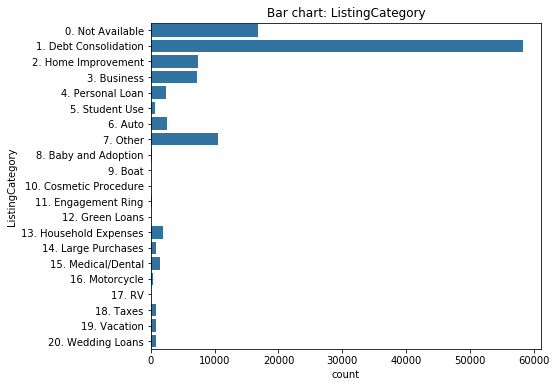

In [28]:
base_color = sb.color_palette()[0]
plt.subplots(figsize = [7,6])

# plotting the distribution of ListingCategory using seaborn's countplot
sb.countplot(data = df, y = 'ListingCategory', color = base_color, order = list(d.values()));

plt.title("Bar chart: ListingCategory");
pd.DataFrame(df['ListingCategory'].value_counts()/df['ListingCategory'].value_counts().sum())

Apparently, debt consolidation is a very large part of Prosper's loan business with 51 percent.
We note that 'Not Available' accounts for a quite large percentage with 14.8 percent.

In order to see the lower frequency types of loans more clearly, we try a log scale for the x-axis.

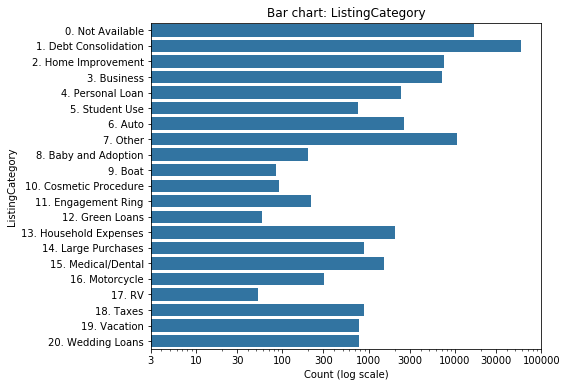

In [29]:
base_color = sb.color_palette()[0]
plt.subplots(figsize = [7,6])

# setting up for xticks suitable for log scale
tick_locs = [3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000] 

# plotting the distribution of ListingCategory using seaborn's countplot
sb.countplot(data = df, y = 'ListingCategory', color = base_color, order = list(d.values()));

plt.xscale('log') # choosing log scale for the x-axis
plt.xticks(tick_locs, tick_locs)
plt.xlabel("Count (log scale)")

plt.title("Bar chart: ListingCategory");

That made it much easier to see the lower frequency listing categories. All categories have at least 50 loans.

#### LoanOrginationDate

Let us have look at how the loans are distributed over time by plotting the 'LoanOriginationDate'.

We plot it in a histogram with 100 bins, which is approximately one bin per month:

C:\Anaconda3\envs\dand\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


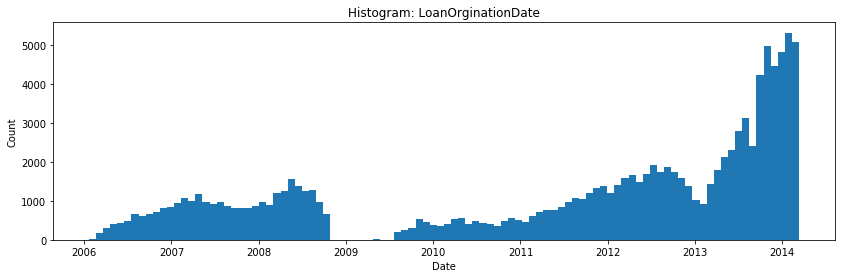

In [30]:
plt.figure(figsize = [14,4])

plt.hist(df["LoanOriginationDate"], bins = 100)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Histogram: LoanOrginationDate');

We can see there is a gap in the data between the fall of 2008 and the mid of 2009. It seems to coincide with the 2008 financial crisis. After the mid of 2009 the volume picks up for Prosper and, after a dip in late 2012, it takes off and the volume more than doubles the next 12 months!

Let us try plotting it with 3000 bins, which is approximately one bin per day:

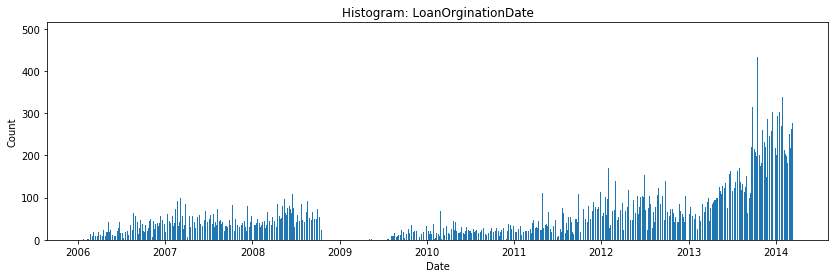

In [31]:
plt.figure(figsize = [14,4])

plt.hist(df["LoanOriginationDate"], bins = 3000)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Histogram: LoanOrginationDate');

How can the small gaps be explained?

In [32]:
df.LoanOriginationDate.dt.weekday.value_counts()

1    27201
2    25195
4    21740
3    21688
0    17813
Name: LoanOriginationDate, dtype: int64

We see that no loans are originated on Saturdays or Sundays, only on weekdays.

#### Year

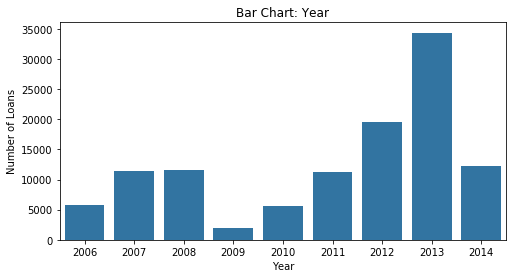

In [33]:
plt.subplots(figsize = [8,4])

sb.countplot(data = df, x = 'Year', color = base_color)

plt.title("Bar Chart: Year")
plt.ylabel("Number of Loans")
plt.xlabel("Year");

This shows the same picture as we saw for the loan origination date. The lower count for 2014 is simply because we only have data for the first few months of this year.

#### LoanOriginalAmount

How does the loan amount distribution look in a plot?

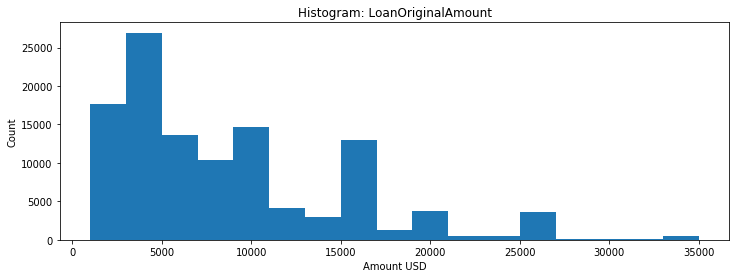

In [34]:
# We will use a histogram for this
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 2000, 2000)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

We can see that there seems to be a lot of smaller loans between \\$1,000 and \\$11,000, and there is a right-skew.

It would be nice to understand better what goes on around the peaks.

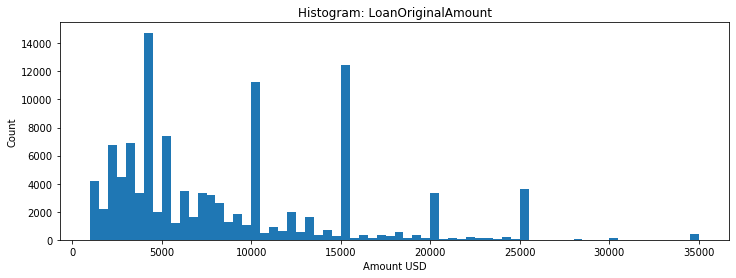

In [35]:
# We will use a histogram again and decrease the bin width compared to last time.
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 500, 500)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

We now recognize the top 3 most common loan amounts: \\$4,000, \\$10,000, \\$15,000, and there seems to be peaks at several round numbers, giving us a multimodal picture.

Maybe we will see some gaps if zoom in even more on those peaks.

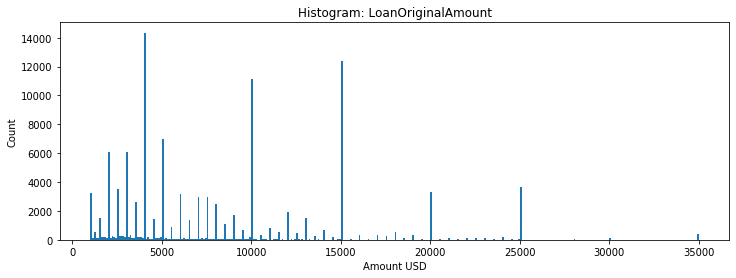

In [36]:
# We will use a histogram again and decrease the bin width even more.
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 100, 100)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

Now we see more clearly that the loan amounts are almost discrete. However there are some odd amounts in between with significantly fewer occurrences than the peaks.

Ok. Now we have a better grasp. And it does make sense that most loan issued are in nice, round numbers.

#### BorrowerAPR

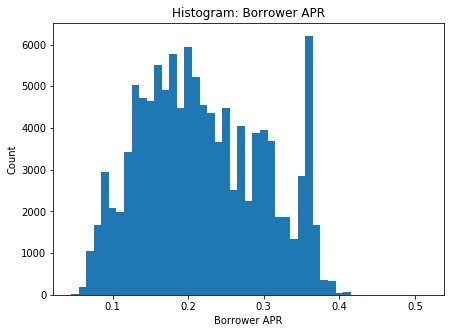

In [37]:
bins = np.arange(0.045, df['BorrowerAPR'].max() + 0.01, 0.01)
plt.subplots(figsize = [7,5])

plt.hist(df['BorrowerAPR'], bins = bins)

plt.xlabel("Borrower APR")
plt.ylabel("Count")
plt.title("Histogram: Borrower APR");

Borrower APR is fairly unimodal except for a peak around 0.36. Is there a particular type of loan with a fixed interest at 0.36?

In [38]:
df['BorrowerAPR'].value_counts()

0.35797    3672
0.35643    1644
0.37453    1260
0.30532     902
0.29510     747
           ... 
0.25094       1
0.29261       1
0.20944       1
0.06535       1
0.24672       1
Name: BorrowerAPR, Length: 6653, dtype: int64

In [39]:
peakAPR = df[(df['BorrowerAPR'] > 0.35796) & (df['BorrowerAPR'] < 0.35798)]
peakAPR

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Year,ProsperRating,ListingCategory,CreditScore
15,0F483544120452347F48121,577164,2012-04-10,NaN,36,Defaulted,2012-12-19,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,5.0,13,FL,Other,Other,121.0,True,False,NaN,2012-04-10,700.0,719.0,1999-03-08 00:00:00,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,3EE2364952142596779635D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,8.0,23,63982,4000,2012-04-19,Q2 2012,924335448287456229847ED,173.71,521.13,209.75,311.38,-9.81,0.00,3790.25,3790.25,0.00,1.0000,0,0,0.0,10,2012,HR,13. Household Expenses,709.5
31,0F683558129866945165D36,643927,2012-09-21,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2896,0.1625,0.1271,1.0,HR,5.0,2,WI,Other,Other,44.0,False,False,NaN,2012-09-21,680.0,699.0,1979-05-01 00:00:00,0.0,0.0,21.0,0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,0.0,0.0,0.00,0.0,20.0,0.60,0.0,0.04,"$25,000-49,999",True,2250.000000,52C13661956879502774109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,18,75030,2000,2012-09-27,Q3 2012,C3EC355869195409459022F,86.85,1476.45,715.61,760.84,-23.95,0.00,0.00,0.00,0.00,1.0000,0,0,0.0,24,2012,HR,2. Home Improvement,689.5
71,0DD23561917467486206661,658787,2012-10-23,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2799,0.1625,0.1174,1.0,HR,4.0,13,CA,Other,Employed,141.0,True,False,NaN,2012-10-23,760.0,779.0,1992-02-01 00:00:00,20.0,14.0,75.0,13,219.0,2.0,11.0,0.0,0.0,4.0,0.0,0.0,7610.0,0.39,11195.0,72.0,1.00,0.0,0.53,"$25,000-49,999",True,2916.666667,668B36670958360892E4068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77739,2774,2012-11-15,Q4 2012,AF7235607399347974B8110,120.47,1807.05,840.76,966.29,-30.43,0.00,0.00,0.00,0.00,0.9247,0,0,0.0,49,2012,HR,13. Household Expenses,769.5
94,0FEE354060248231998406E,563980,2012-02-29,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,3.0,7,MO,Military Officer,Employed,33.0,True,False,NaN,2012-02-29,700.0,719.0,2005-09-20 00:00:00,15.0,13.0,23.0,7,478.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,17878.0,0.92,833.0,17.0,1.00,3.0,0.43,"$50,000-74,999",True,5196.250000,25013645183307735D78AF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,24,61584,4000,2012-03-05,Q1 2012,2B163539729377704DEE232,173.71,3995.33,2101.75,1893.58,-59.58,0.00,0.00,0.00,0.00,1.0000,0,0,0.0,6,2012,HR,7. Other,709.5
107,10BE354254173728633D033,573446,2012-03-29,NaN,36,Defaulted,2012-12-23,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,2.0,1,OH,

In [40]:
peakAPR.ProsperRating.value_counts()

HR    3672
AA       0
A        0
B        0
C        0
D        0
E        0
Name: ProsperRating, dtype: int64

They all have ProsperRating 'HR'. In later bi-variate plot we should surely pair up BorrowerAPR with ProsperRating.

#### Term

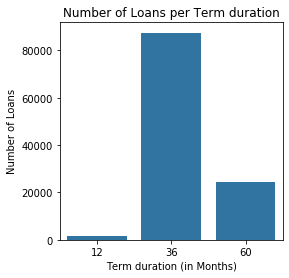

In [41]:
plt.subplots(figsize = [4,4])

sb.countplot(data = df, x = 'Term', color = base_color)

plt.title("Number of Loans per Term duration")
plt.ylabel("Number of Loans")
plt.xlabel("Term duration (in Months)");

Let us plot it in relative terms as well:

In [42]:
# create set of evenly spaced tick_props and some tick_names

term_counts = df['Term'].value_counts()
n = df.shape[0]
max_term_count = term_counts.max()
max_prop = max_term_count/n
tick_props = np.arange(0, max_prop + 0.1, 0.1)

tick_names = ['{:0.2f}'.format(v) for v in tick_props]

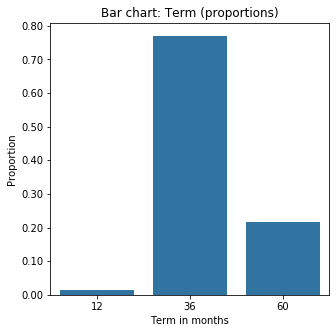

In [43]:
plt.subplots(figsize = [5,5])

sb.countplot(data = df, x = 'Term', color = base_color)

plt.yticks(tick_props*n, tick_names)
plt.xlabel("Term in months")
plt.ylabel("Proportion")
plt.title("Bar chart: Term (proportions)");

Ok. Now we can see the proportional values from the barchart.

#### LoanStatus

,LoanStatus
Current,0.499223
Completed,0.334286
Chargedoff,0.105446
Defaulted,0.043679
Past Due (1-15 days),0.007112
Past Due (31-60 days),0.003203
Past Due (61-90 days),0.002762
Past Due (16-30 days),0.002338
FinalPaymentInProgress,0.001809
Past Due (>120 days),0.000141


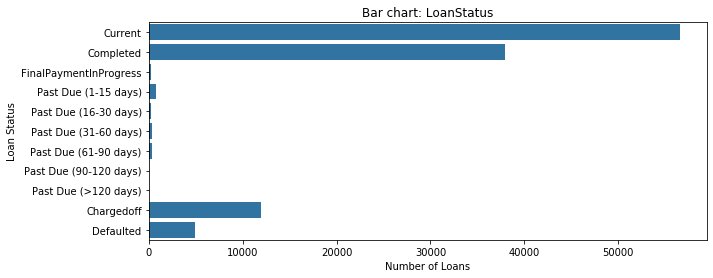

In [44]:
plt.subplots(figsize = [10,4])

sb.countplot(data = df, y = 'LoanStatus', color = base_color)

plt.title("Bar chart: LoanStatus")
plt.xlabel("Number of Loans")
plt.ylabel("Loan Status");
pd.DataFrame(df['LoanStatus'].value_counts()/df['LoanStatus'].value_counts().sum())

50 percent is Current, 33 percent is Completed, 11 percent is Chargedoff and 4 percent is Defaulted. These four values account for 98 percent of the loans. 

The rest is hard to read from the chart, so let us plot it again with a log scale on the x-axis:

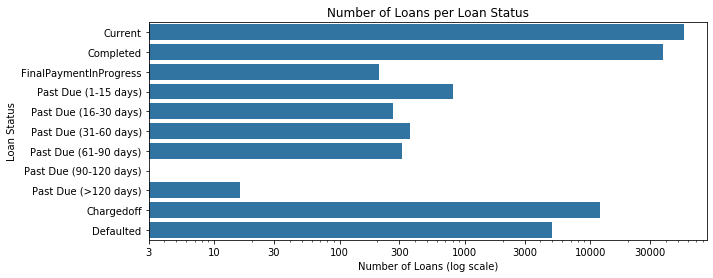

In [45]:
tick_locs = [3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.subplots(figsize = [10,4])

sb.countplot(data = df, y = 'LoanStatus', color = base_color);

plt.xscale('log')
plt.xticks(tick_locs, tick_locs)
plt.xlabel("Number of Loans (log scale)")
plt.ylabel("Loan Status")
plt.title("Number of Loans per Loan Status");

Now it's easier to read, and if we compare the PastDue ranges, they are pretty evenly distributed up to 90 days with 200-1000 loans each. After the 90 day point there are way fewer when the threat of being chargedoff comes closer. There might be some warning letters distributed in advance, but that we cannot say for sure. Regardsless, we do not plan to dive into the payment problems, as also stated in the Introduction. 

### Credit Grades / Prosper Ratings

Due to the fact that we merged CreditGrade into the ProsperRating, only the latter is a variable of interest in this category in addition to CreditScoreAvg.

#### ProsperRating

ProsperRating is a categorical variable. A bar chart should be a suitable plot.

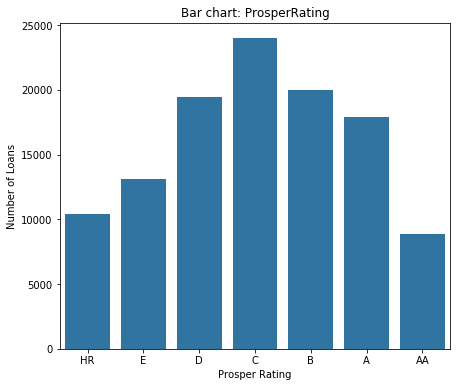

In [46]:
plt.subplots(figsize = [7,6])

sb.countplot(data = df, x = 'ProsperRating', color = base_color)

plt.title("Bar chart: ProsperRating")
plt.ylabel("Number of Loans")
plt.xlabel("Prosper Rating");

The distribution looks unimodal and quite symmertric, with the middle rating C having the highest count of loans.

#### CreditScore

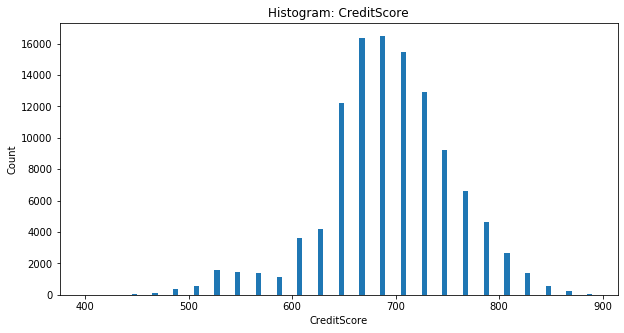

In [49]:
bins = np.arange(400, df['CreditScore'].max() + 5, 5)
plt.subplots(figsize = [10,5])

plt.hist(df['CreditScore'], bins = bins)

plt.xlabel("CreditScore")
plt.ylabel("Count")
plt.title("Histogram: CreditScore");

We see that the distributionis unimodal and quite normal and symmetric. It is however discrete.

### Data That Might Have Affected Credit Prosper Ratings

#### Employment Status

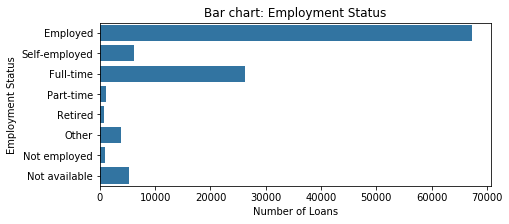

In [50]:
plt.subplots(figsize = [7,3])

sb.countplot(data = df, y = 'EmploymentStatus', color = base_color);

plt.xlabel("Number of Loans")
plt.ylabel("Employment Status")
plt.title("Bar chart: Employment Status");

The categories aren't great. 'Employed' is most likely a mix of Self-Employed, Full-time and Part-time. And with 'Employed' as the most frequent value, I believe we will not use it in future bivariate and multivariate exploration.

#### IncomeRange

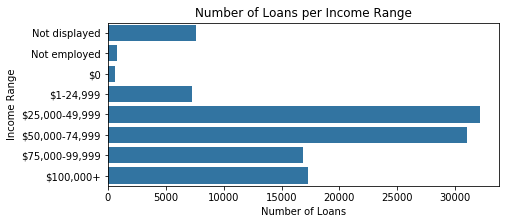

In [51]:
plt.subplots(figsize = [7,3])

sb.countplot(data = df, y = 'IncomeRange', color = base_color);

plt.xlabel("Number of Loans")
plt.ylabel("Income Range")
plt.title("Number of Loans per Income Range");

Income ranges are well-defined and we have a good amount of data points in each range, unimodal with a peak around 50k dollars. This variable can definately be used in future bivariate/multivariate exploration.

#### IsBorrowerHomeowner

,IsBorrowerHomeowner
True,0.505214
False,0.494786


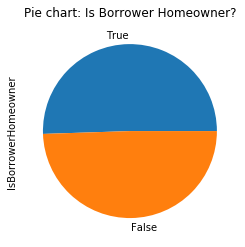

In [52]:
ax = df['IsBorrowerHomeowner'].value_counts().plot(kind='pie')
ax.set_title('Pie chart: Is Borrower Homeowner?')
pd.DataFrame(df['IsBorrowerHomeowner'].value_counts()/df['IsBorrowerHomeowner'].value_counts().sum())

Only a slight majority are homeowners (50.5 percent). This could be used for later bi-/multi-variate exploration if it turns out to be a good indicator.

#### OnTimeProsperPayments

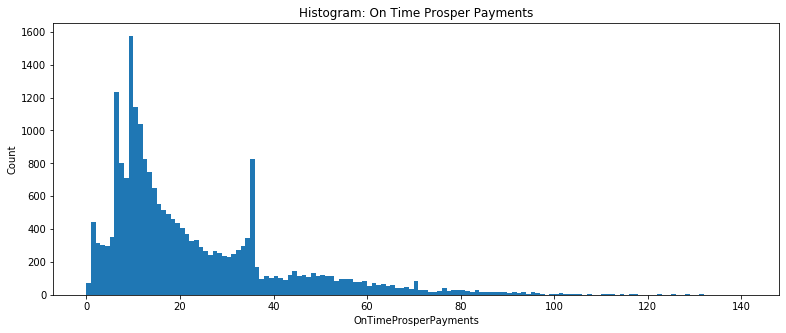

In [53]:
bins = np.arange(0, df['OnTimeProsperPayments'].max() + 1, 1)
plt.subplots(figsize = [13,5])

plt.hist(df['OnTimeProsperPayments'], bins = bins)

plt.xlabel("OnTimeProsperPayments")
plt.ylabel("Count")
plt.title("Histogram: On Time Prosper Payments");

For 'OnTimeProsperPayments' there are peaks arond 10-12 and 36. There are a lot of Current loans (ongoing) with longer term that clouds the picture that 12 is a "good" number. It would be more likely that 36 is a "good" number, because 36 months is the most common duration of a loan. A high number like 80 could be good, but it could also be bad, because there could be several small loans in the history of a borrower with high average APR, for instance, and I would think there is less reason to think that 80 means 80 out of 80 where paid on time compared to 36 meaning 36 out of 36. It would be better to have this as a percentage. Then 100 percent ontime payment would certainly be a positive. I do not think this will be too valuable in future multivariate plots, but who knows. 

#### Recommendations

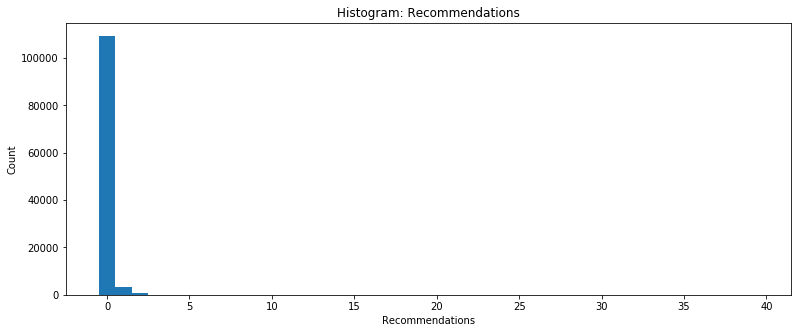

In [54]:
bins = np.arange(-0.5, df['Recommendations'].max() + 1, 1)
plt.subplots(figsize = [13,5])

plt.hist(df['Recommendations'], bins = bins)

plt.xlabel("Recommendations")
plt.ylabel("Count")
plt.title("Histogram: Recommendations");

Clearly recommendations are rare. Most borrowers have zero. Let us try this with a log scale on the y-axis:

,Recommendations
0,0.962609
1,0.030861
2,0.004990
3,0.000950
4,0.000229
5,0.000123
9,0.000053
7,0.000044
6,0.000035
8,0.000026


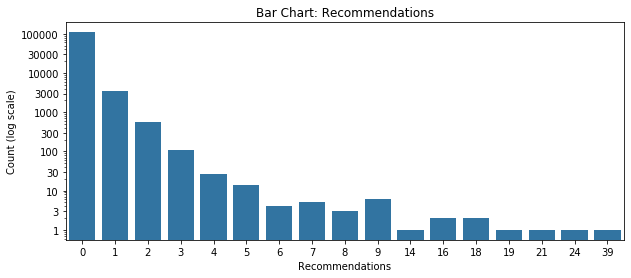

In [55]:
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.subplots(figsize = [10,4])

sb.countplot(data = df, x = 'Recommendations', color = base_color);

plt.yscale('log')
plt.yticks(tick_locs, tick_locs)
plt.ylabel("Count (log scale)")
plt.xlabel("Recommendations")
plt.title("Bar Chart: Recommendations");
pd.DataFrame(df['Recommendations'].value_counts()/df['Recommendations'].value_counts().sum())

3.1 percent have 1 recommendation.
0.5 percent have 2 recommendations.
0.1 percent have 3 recommendations.
etc.

So few have them, but does that mean they are valuable? We will find out in later chapters.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
ListingCategory (log transform) - debt consolidation is a very large part of Prosper's loan business with 51 percent.
We note that 'Not Available' accounts for a quite large percentage with 14.8 percent.

LoanOriginationDate - revealed a gap in new business around the financial crisis, or maybe they were out of business. Then the volumes of loans originated skyrocketed the last one year 2013-14 and more than doubled.

LoanOrginalAmount - common loan sizes at round numbers like 4k, 10k and 15k dollars leads to many peaks.

Term - plotted both an absolute and a relative bar chart. 36 months the most common duration.

LoanStatus (log transform) - Current/Completed/ChargedOff/Defaulted the most common categories

ProsperRating - nice unimodal and symmetric distribution

CreditScoreAvg - nice unimodal, quite normal and symmetric distribution, and it's discrete

IncomeRange - good amount of data points in each range, unimodal with a peak around 50k dollars

IsBorrowerHomeowner - Almost 50/50

OnTimeProsperPayments - maybe not that useful, since it say anything about the proportion of on time payments.

Recommendations (log transform) - 96.2 percent of loans, the borrower does not have recommendations


### Of the features you investigated, were there any unusual distributions? 
Yes, the ones where I did a log transform, there where a lot of values with very low frequency. Log transform was necessary to distinguish them.

### Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Yes, for ProsperRating I added a new column where I first took all the data from column 'ProsperRating (Alpha)'s and then populated its missing values (pre-2009) with data from 'CreditGrade'. This was possible because it follows the same rating scale (AA - A - B - C - D - E - HR).

And for 'ListingCategory (numeric)' I added text and put it in a new column 'ListingCategory' for improved readability and turned it into an ordered categorical type.

## Bivariate Exploration

Let us do a quick recap of our 14 variables:
- 1 is a datetime variable: 'LoanOriginationDate'.
- 6 are categorical variables: 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange', 'EmploymentStatus' and 'ProsperRating'.
- 5 are numeric variables: 'LoanOrginationAmount', 'BorrowerAPR', 'CreditScoreAvg', 'OnTimeProsperPayments', 'Recommendations'.
- 1 is a boolean variable: 'IsBorrowerHomeowner'.
- 1 is of string format: 'BorrowerState'

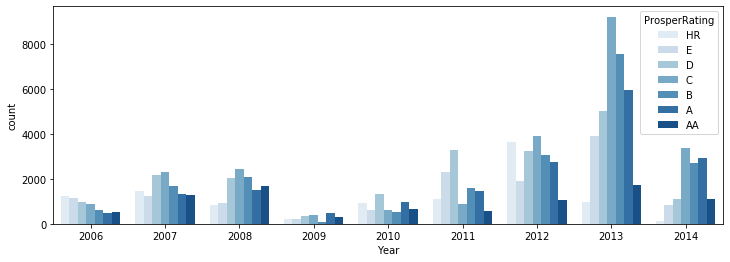

In [57]:
plt.subplots(figsize = [12,4])

sb.countplot(data = df, x = 'Year', hue = 'ProsperRating', palette = 'Blues');

In [58]:
# create set of evenly spaced tick_props and some tick_names

term_counts = df['ProsperRating'].value_counts()
n = df.shape[0]
max_term_count = term_counts.max()
max_prop = max_term_count/n
tick_props = np.arange(0, max_prop + 0.1, 0.1)

tick_names = ['{:0.2f}'.format(v) for v in tick_props]

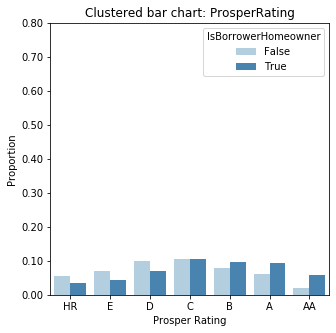

In [93]:
plt.subplots(figsize = [5,5])

sb.countplot(data = df, x = 'ProsperRating', hue = 'IsBorrowerHomeowner', palette = 'Blues')

plt.yticks(tick_props*n, tick_names)
plt.xlabel("Prosper Rating")
plt.ylabel("Proportion")
plt.title("Clustered bar chart: ProsperRating");

In [60]:
# create set of evenly spaced tick_props and some tick_names

term_counts = df['Term'].value_counts()
n = df.shape[0]
max_term_count = term_counts.max()
max_prop = max_term_count/n
tick_props = np.arange(0, max_prop + 0.1, 0.1)

tick_names = ['{:0.2f}'.format(v) for v in tick_props]

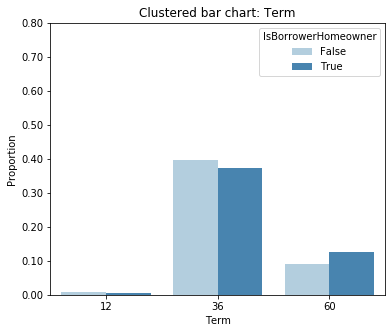

In [61]:
plt.subplots(figsize = [6,5])

sb.countplot(data = df, x = 'Term', hue = 'IsBorrowerHomeowner', palette = 'Blues')

plt.yticks(tick_props*n, tick_names)
plt.xlabel("Term")
plt.ylabel("Proportion")
plt.title("Clustered bar chart: Term");

Homeowners tend to get the 60 month term more often than non-homeowners. 

In [64]:
numeric_vars = ['BorrowerAPR', 'Year', 'CreditScore', 'LoanOriginalAmount', 'Recommendations']
categoric_vars = ['ProsperRating', 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange']

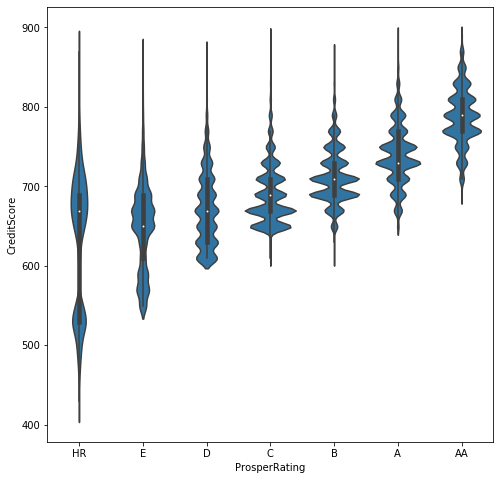

In [65]:
plt.figure(figsize = [8, 8])
sb.violinplot(data = df, x='ProsperRating', y='CreditScore', color=base_color);

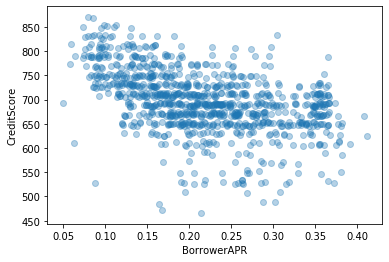

In [66]:
df_sample = df.sample(1000)

sb.regplot(data = df_sample, x = 'BorrowerAPR', y = 'CreditScore', fit_reg = False, 
           y_jitter = 5, x_jitter = 0.01, scatter_kws = {'alpha' : 1/3});

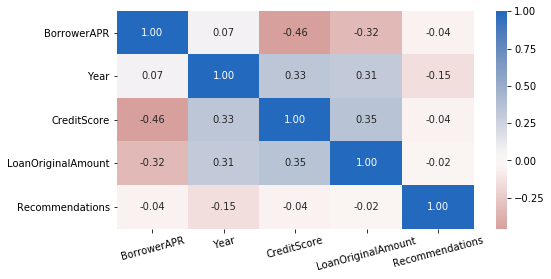

In [67]:
# correlation plot
plt.figure(figsize = [8, 4])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0)
plt.xticks(rotation = 15)
plt.show()

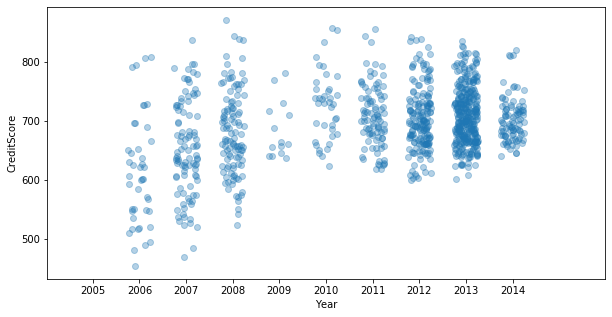

In [68]:
df_sample = df.sample(1000)

plt.figure(figsize = [10, 5])

sb.regplot(data = df_sample, x = 'Year', y = 'CreditScore', fit_reg = False, 
           y_jitter = 10, x_jitter = 0.25, scatter_kws = {'alpha' : 1/3})

plt.xticks(np.arange(2005, 2014 + 1, 1));

We see that the yearly lower bound for CreditScoreAvg is around 500 in 2006-08, while it's around 600 in 2009-14. Since our data are for approved and listed loans, it might be that post-2008 someone with a CreditScore average of less that 600 would not get a loan from Prosper.

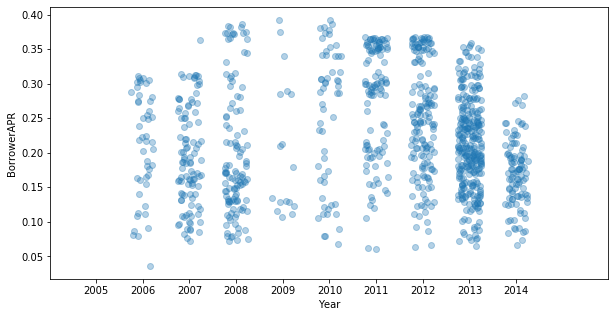

In [69]:
df_sample = df.sample(1000)

plt.figure(figsize = [10, 5])

sb.regplot(data = df_sample, x = 'Year', y = 'BorrowerAPR', fit_reg = False, 
           y_jitter = 0.01, x_jitter = 0.25, scatter_kws = {'alpha' : 1/3})

plt.xticks(np.arange(2005, 2014 + 1, 1));

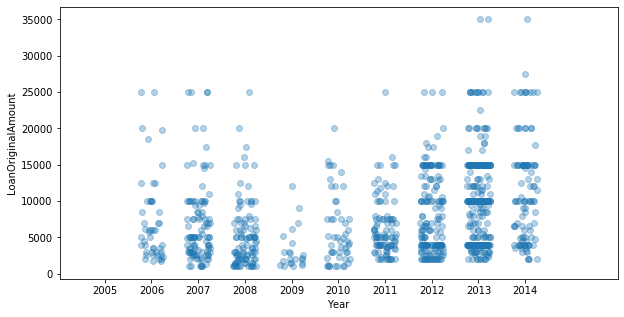

In [70]:
df_sample = df.sample(1000)

plt.figure(figsize = [10, 5])

sb.regplot(data = df_sample, x = 'Year', y = 'LoanOriginalAmount', fit_reg = False, 
           y_jitter = 0, x_jitter = 0.25, scatter_kws = {'alpha' : 1/3})

plt.xticks(np.arange(2005, 2014 + 1, 1));

C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


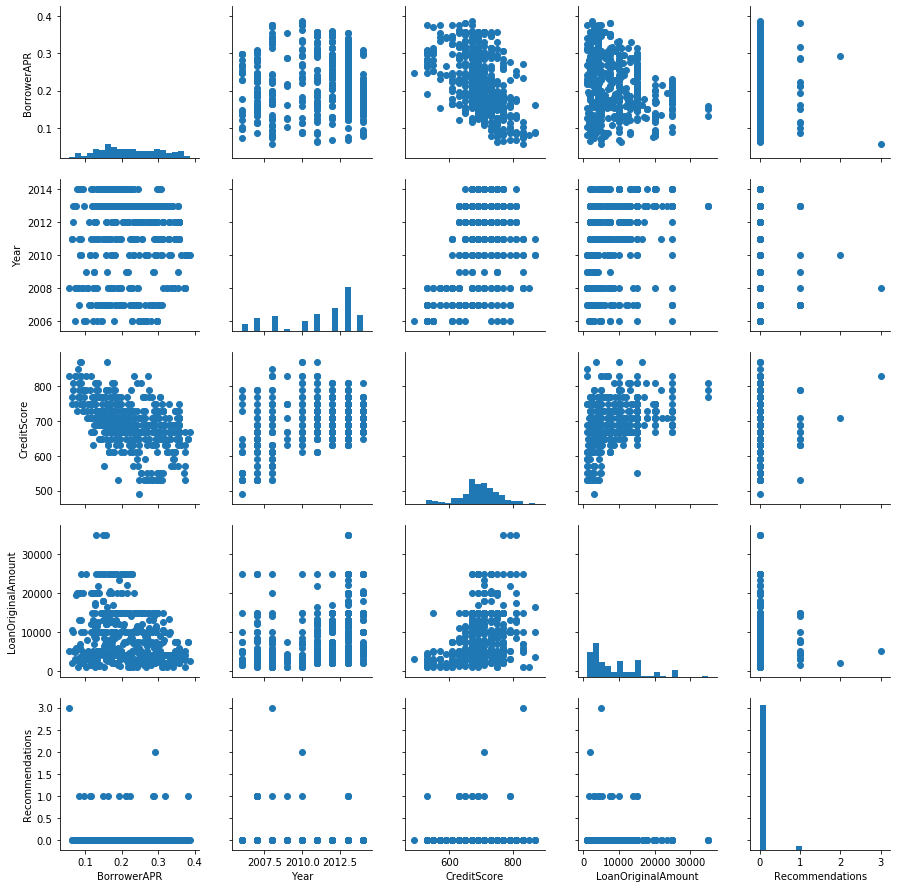

In [71]:
# plot matrix: sample 500 loans so that plots are clearer and
# they render faster
samples = np.random.choice(df.shape[0], 500, replace = False)
df_samp = df.loc[samples,:]

g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

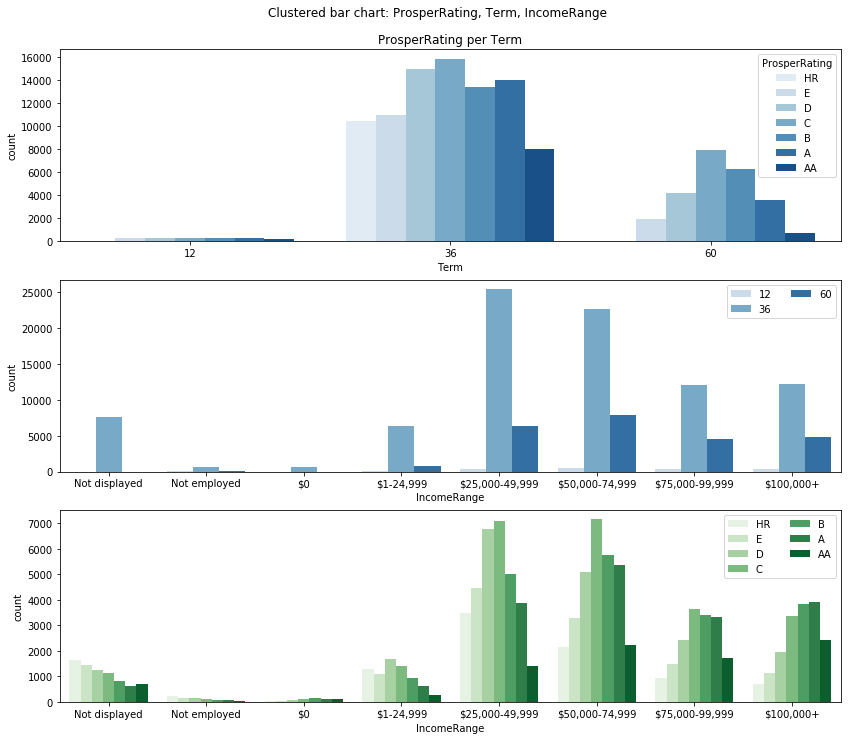

In [73]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [14, 12])

# subplot 1: ProsperRating vs Term
plt.subplot(3, 1, 1)
sb.countplot(data = df, x = 'Term', hue = 'ProsperRating', palette = 'Blues')
plt.title('ProsperRating per Term')
plt.suptitle('Clustered bar chart: ProsperRating, Term, IncomeRange', x = 0.5, y=0.93)

# subplot 2: IncomeRange vs. Term
ax = plt.subplot(3, 1, 2)
sb.countplot(data = df, x = 'IncomeRange', hue = 'Term', palette = 'Blues')
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping

# subplot 3: IncomeRange vs. color, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = df, x = 'IncomeRange', hue = 'ProsperRating', palette = 'Greens')
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping

plt.show()

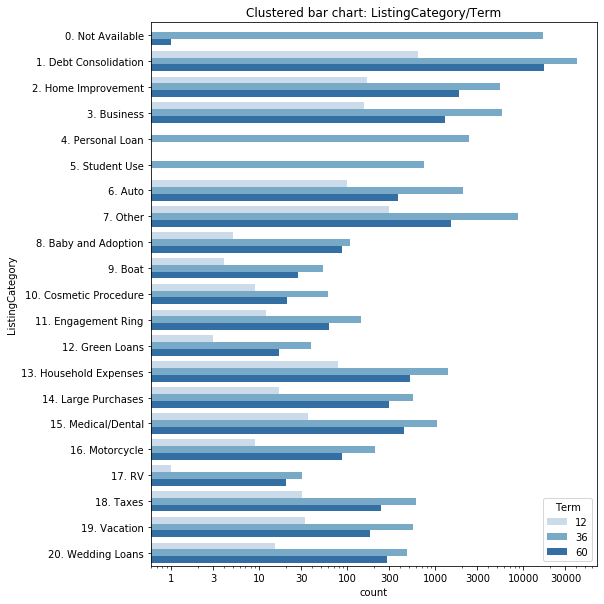

In [74]:
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.figure(figsize = [8, 10])

sb.countplot(data = df, y = 'ListingCategory', hue = 'Term', palette = 'Blues')

plt.xscale('log')
plt.xticks(tick_locs, tick_locs)
plt.title('Clustered bar chart: ListingCategory/Term');

Let us use a line chart to see how the average BorrowerAPR changes over time

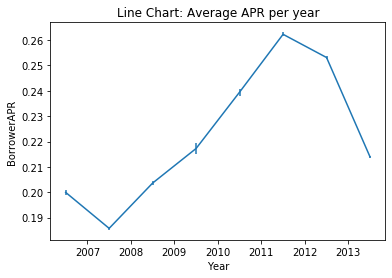

In [75]:
# set bin edges, compute centers
bin_size = 1
xbin_edges = np.arange(2006, df['Year'].max()+bin_size, bin_size)
xbin_centers = (xbin_edges + bin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(df['Year'], xbin_edges, right = False, include_lowest = True)
y_means = df['BorrowerAPR'].groupby(data_xbins).mean()
y_sems = df['BorrowerAPR'].groupby(data_xbins).sem()

# plot the summarized data
plt.errorbar(x = xbin_centers, y = y_means, yerr = y_sems);
plt.xlabel('Year')
plt.ylabel('BorrowerAPR')
plt.title('Line Chart: Average APR per year');

We see that the average APR for 2007 was the low point at less than 0.19, while in the next few years the interest rate kept climbing until 2011 and then started to fall again with a steep decline in 2013. 

Note that it's at the half-way point between 2007 and 2008 on the x-axis, that the average for 2007 can be read from the line in the chart.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

It's time to do some multivarite exploration. Mostly, we will look at the interaction between 3 variables.

We saw in our bivariate exploration that was a weak negative correlation between BorrowerAPR and CreditScore.

Now let's look at a scatter plot of the two, where we also distinguish whether the borrower is a homeowner or not.

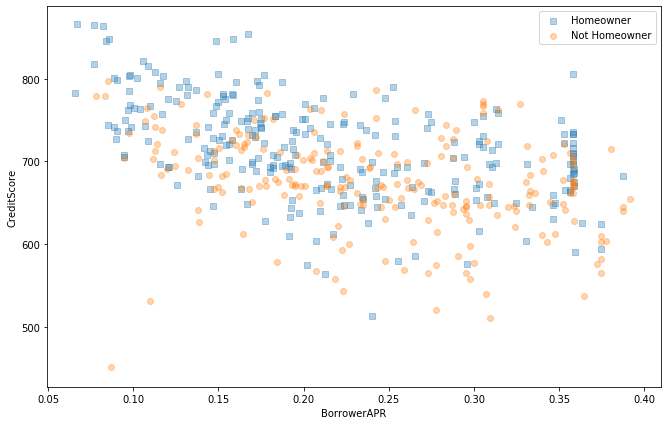

In [134]:
# we start with a sample of df in order to make the plot less crowded
df_sample = df.sample(500)

# we indicate square and round markers that are built in markers in matplotlib
cat_markers = [[True, 's'],
               [False, 'o']]

plt.figure(figsize = [11, 7])

for cat, marker in cat_markers:
    # We loop through both categories (true and false) and it's markers.
    # We also use some transparency and vertical jitter to be able to see the markers better 
    df_cat = df_sample[df_sample['IsBorrowerHomeowner'] == cat]
    sb.regplot(data = df_cat, x = 'BorrowerAPR', y = 'CreditScore', marker = marker, fit_reg = False, 
           y_jitter = 10, x_jitter = 0, scatter_kws = {'alpha' : 1/3})
plt.legend(['Homeowner','Not Homeowner']);

It's clear that homeowners, generally, get higher credit scores. However, it is a bit strange that even homeowners with high credit scores have a wide range in APR. Maybe they are not getting the rate they deserve? Or, maybe, it depends more heavily on the year, as the general interest rates have varied a lot during the time period.

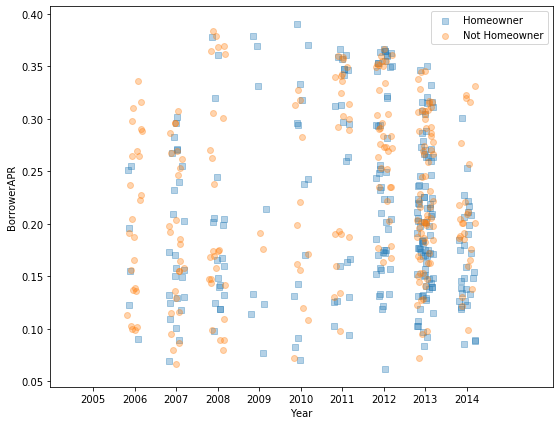

In [77]:
df_sample = df.sample(500)

cat_markers = [[True, 's'],
               [False, 'o']]

plt.figure(figsize = [9, 7])

for cat, marker in cat_markers:
    df_cat = df_sample[df_sample['IsBorrowerHomeowner'] == cat]
    sb.regplot(data = df_cat, x = 'Year', y = 'BorrowerAPR', marker = marker, fit_reg = False, 
           y_jitter = 0.01, x_jitter = 0.2, scatter_kws = {'alpha' : 1/3})
plt.xticks(np.arange(2005, 2014 + 1, 1))
plt.legend(['Homeowner','Not Homeowner']);


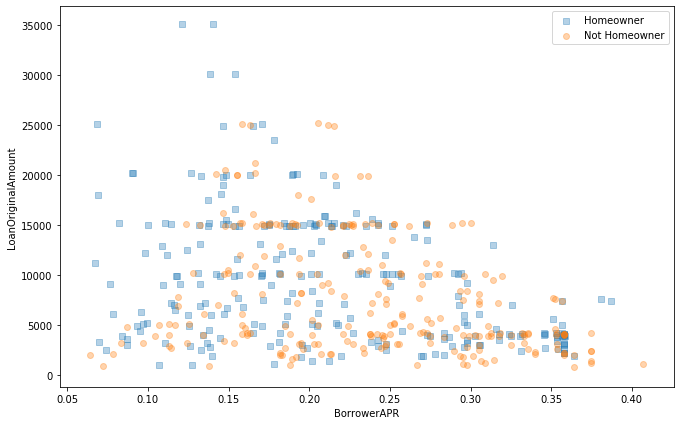

In [78]:
df_sample = df.sample(500)

cat_markers = [[True, 's'],
               [False, 'o']]

plt.figure(figsize = [11, 7])

for cat, marker in cat_markers:
    df_cat = df_sample[df_sample['IsBorrowerHomeowner'] == cat]
    sb.regplot(data = df_cat, x = 'BorrowerAPR', y = 'LoanOriginalAmount', marker = marker, fit_reg = False, 
           y_jitter = 200, x_jitter = 0, scatter_kws = {'alpha' : 1/3})
plt.legend(['Homeowner','Not Homeowner']);

In [79]:
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

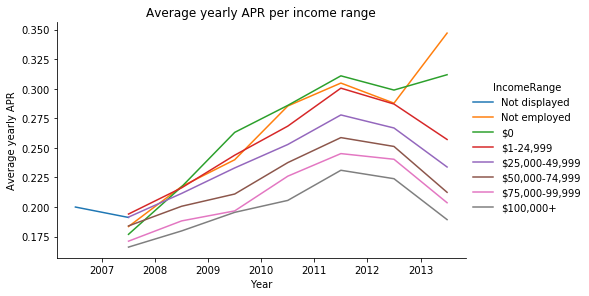

In [80]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'IncomeRange', height = 4, aspect = 1.7)
g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average yearly APR')
g.add_legend()
plt.title('Average yearly APR per income range');

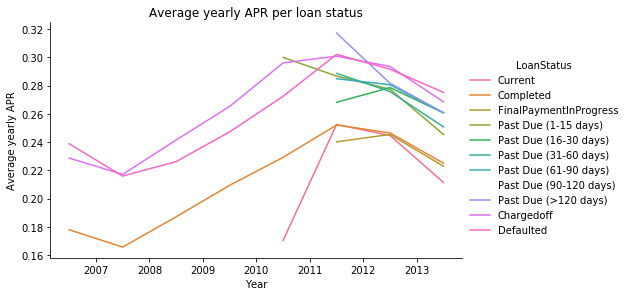

In [81]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'LoanStatus', height = 4, aspect = 1.7)
g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average yearly APR')
g.add_legend()
plt.title('Average yearly APR per loan status');

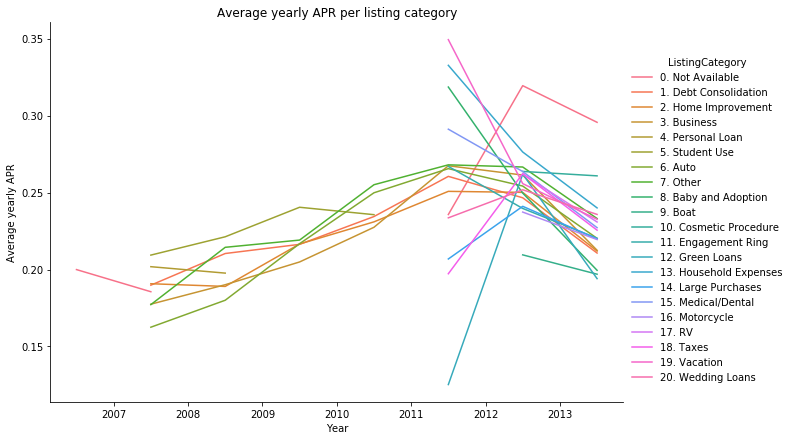

In [82]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'ListingCategory', height = 6, aspect = 1.5)
g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average yearly APR')
g.add_legend()
plt.title('Average yearly APR per listing category');

Let's try something a bit crazy and let CreditScore be the hue instead, even though this is numerical and not categorical.

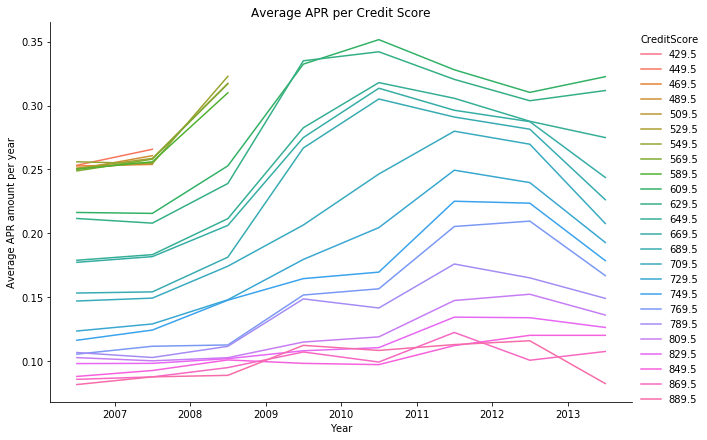

In [91]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'CreditScore', height = 6, aspect = 1.5)
g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average APR amount per year')
g.add_legend()
plt.title('Average APR per Credit Score');

That worked surprisingly well. Because the credit scores are evenly spaced with 20 points between each, they are in effect just like a categorical. And even though there are as much as 24 "categories", it is mostly just 15, because the 9 lowest credit scores only appear pre-2009.

It is clear from the plot that the credit score, to a large extent, dictates the APR. Of course this is APR averages for each year, so on individual loan level the picture is more varied. Therefore, this plot would be really helpful for a borrower who knows his/her credit score and wants to check whether they are getting a fair interest rate. And ideally from a customer perspective, the borrower would want to know this before the loan gets listed, in order to be able to negotiate.

We also note that there are many crossing lines at the bottom of the plot (high credit ratings). These might be the most solid borrowers with low risk that Prosper really wants. So they could have more room for negotiating on the interest rates AND they might understand they're in a good position to do so.

Let's do the same for ProsperRating:

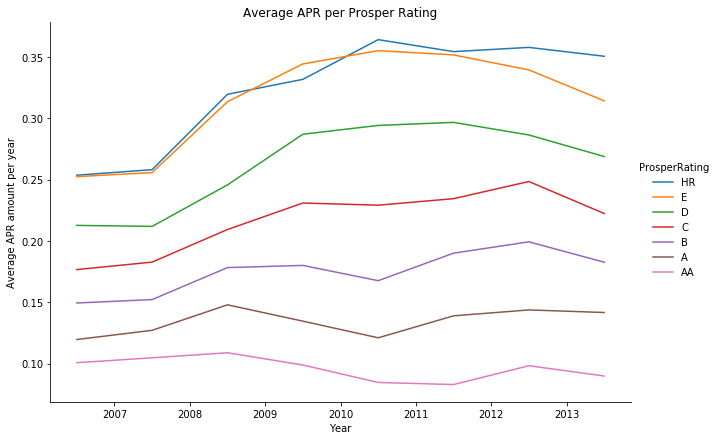

In [92]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'ProsperRating', height = 6, aspect = 1.5)
g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average APR amount per year')
g.add_legend()
plt.title('Average APR per Prosper Rating');

Just like for credit rating the Prosper Rating seems crucial when it comes to the APR. I do not know whether the Prosper Rating is shared with the borrower or if it's internal to Prosper. If it is shared, this chart could be used by the borrower to check their level in the same way as I explained for credit score.

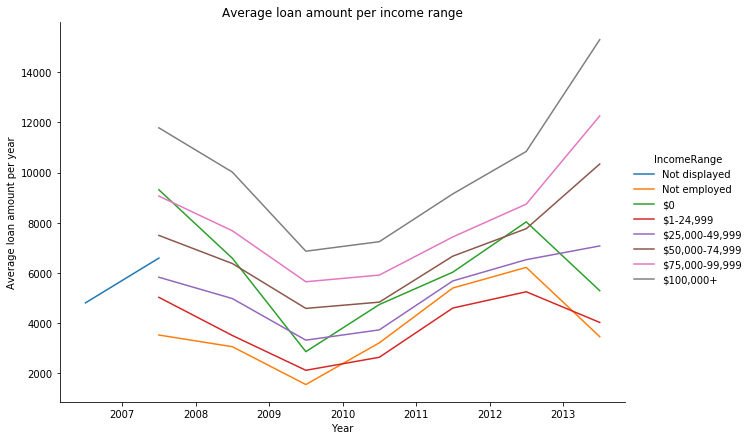

In [83]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'IncomeRange', height = 6, aspect = 1.5)
g.map(mean_poly, "Year", "LoanOriginalAmount", bins = bin_edges)
g.set_ylabels('Average loan amount per year')
g.add_legend()
plt.title('Average loan amount per income range');

We see that the average loan amount depends a lot on the income range. Each level is separate over the years. One exception though is the income of "\\$0". Most of the years it's above the ranges "\\$1-24,999" and "\\$25,000-49,999". That's strange. 

Let's have a closer look at how the zero income subset differs.

In [127]:
# New DataFrame 'df0' will contain loans where reported income range is $0.
df0 = df[df['IncomeRange'] == '$0']

We compare ListingCategory between the full df and our new df0:

In [130]:
h = df.ListingCategory.value_counts()/df.ListingCategory.value_counts().sum()
print('Top 5 listing category overall')
print(h[:5])

Top 5 listing category overall
1. Debt Consolidation    0.512527
0. Not Available         0.147804
7. Other                 0.092135
2. Home Improvement      0.065313
3. Business              0.063113
Name: ListingCategory, dtype: float64


In [124]:
h = df0.ListingCategory.value_counts()/df0.ListingCategory.value_counts().sum()
print('Top 5 listing category w/ IncomeRange = $0')
print(h[:5])

Top 5 listing category w/ IncomeRange = $0
0. Not Available         0.294686
3. Business              0.252818
4. Personal Loan         0.169082
1. Debt Consolidation    0.156200
7. Other                 0.049919
Name: ListingCategory, dtype: float64


We compare EmploymentStatus between the full df and our new df0:

In [122]:
h = df.EmploymentStatus.value_counts()/df.Occupation.value_counts().sum()
print('Top 5 employment statuses overall')
print(h[:5])

Top 5 employment statuses overall
Employed         0.611264
Full-time        0.238394
Self-employed    0.055669
Not available    0.047632
Other            0.034564
Name: EmploymentStatus, dtype: float64


In [121]:
h = df0.EmploymentStatus.value_counts()/df0.EmploymentStatus.value_counts().sum()
print('Top 5 employment statuses w/ IncomeRange = $0')
print(h[:5])

Top 5 employment statuses w/ IncomeRange = $0
Full-time        0.466989
Self-employed    0.413849
Part-time        0.074074
Not employed     0.017713
Employed         0.016103
Name: EmploymentStatus, dtype: float64


We compare Occupation between the full df and our new df0:

In [119]:
h = df.Occupation.value_counts()/df.Occupation.value_counts().sum()
print('Top 5 occupations overall')
print(h[:5])

Top 5 occupations overall
Other                  0.259345
Professional           0.123533
Computer Programmer    0.040566
Executive              0.039113
Teacher                0.034091
Name: Occupation, dtype: float64


In [118]:
h = df0.Occupation.value_counts()/df0.Occupation.value_counts().sum()
print('Top 5 occupations w/ IncomeRange = $0')
print(h[:5])

Top 5 occupations w/ IncomeRange = $0
Other                 0.452496
Sales - Retail        0.057971
Professional          0.056361
Sales - Commission    0.054750
Construction          0.041868
Name: Occupation, dtype: float64


ListingCategory: 
- Less Debt consolidation (16 vs. 51 percent)
- More Business (25 vs. 6 percent), Not available (29 vs. 15 percent) and Personal Loan (17 vs. 2 percent)

EmploymentStatus:
- Less Employed (61 vs. 2 percent)
- More Full-time (47 vs. 24 percent) and Self-employed (41 vs. 6 percent)

Occupation:
- More Other (45 vs. 26 percent)
- Less Professional (12 vs. 6 percent)

It seems the income range of \\$0 is not at all the same as Not Employed. Many of them are full-time and/or self-employed and are doing less Debt Consolidation, but rather having Business/Personal/Other type of loans.

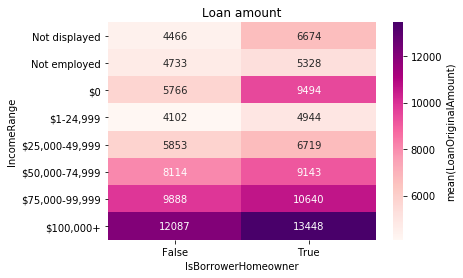

In [88]:
cat_means = df.groupby(['IsBorrowerHomeowner', 'IncomeRange']).mean()['LoanOriginalAmount']
cat_means = cat_means.reset_index(name = 'LoanOriginalAmount_avg')
cat_means = cat_means.pivot(index = 'IncomeRange', columns = 'IsBorrowerHomeowner',
                            values = 'LoanOriginalAmount_avg')
sb.heatmap(cat_means, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'mean(LoanOriginalAmount)'}, cmap="RdPu")
plt.title('Loan amount');

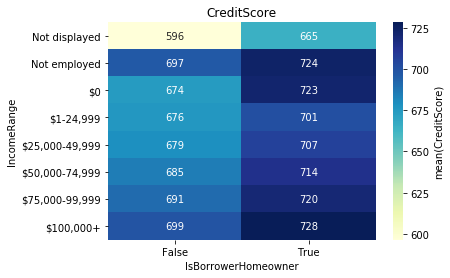

In [86]:
cat_means = df.groupby(['IsBorrowerHomeowner', 'IncomeRange']).mean()['CreditScore']
cat_means = cat_means.reset_index(name = 'CreditScore_avg')
cat_means = cat_means.pivot(index = 'IncomeRange', columns = 'IsBorrowerHomeowner',
                            values = 'CreditScore_avg')
sb.heatmap(cat_means, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'mean(CreditScore)'}, cmap="YlGnBu")
plt.title('CreditScore');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!